# Init

In [21]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [22]:
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader

In [23]:
# Initialize torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Generate Dataset

In [24]:
# Create dummy dataset with equation: y = 3x + 4
num_points = 100
np.random.seed(10)
X = 2 * np.random.rand(num_points, 1)
y = 4 + 3 * X + np.random.randn(num_points, 1)

In [25]:
# Data shape
print(X.shape)
print(y.shape)

(100, 1)
(100, 1)


Text(0, 0.5, 'Output')

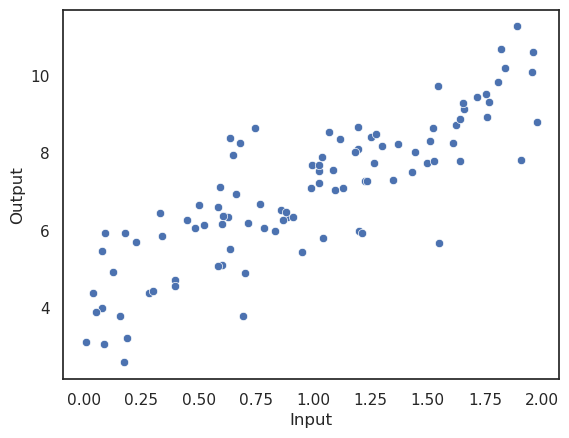

In [26]:
# Plot data
sns.scatterplot(x=X.flatten(), y=y.flatten())
sns.set(style='white')
plt.xlabel('Input')
plt.ylabel('Output')

In [27]:
# Split data in train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train - X:{X_train.shape}, y:{y_train.shape}')
print(f'Test  - X:{X_test.shape}, y:{y_test.shape}')

Train - X:(80, 1), y:(80, 1)
Test  - X:(20, 1), y:(20, 1)


In [28]:
# Data loader class
class Dataset(torch.utils.data.Dataset):

    # Constructor
    def __init__(self, data, targets):
        self.data = data.astype(np.float32)
        self.targets = targets.astype(np.float32)

    # Get item
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

    # Length
    def __len__(self):
        return len(self.data)

In [29]:
# Create dataloaders
train_dataloader = DataLoader(Dataset(X_train, y_train), batch_size=20)
test_dataloader = DataLoader(Dataset(X_test, y_test), batch_size=20)

# Model

In [30]:
# Model class
class LinearRegressionModel(nn.Module):

    # Constructor
    def __init__(self, input_shape):
        super().__init__()
        assert len(input_shape) == 2
        self.data_dims = input_shape[1]
        self.w = nn.Parameter(torch.ones((self.data_dims, 1)), requires_grad=True)
        self.b = nn.Parameter(torch.tensor(0.0), requires_grad=True)

    # Forward pass
    def forward(self, input):
        assert len(input.shape) == 2
        assert input.shape[1] == self.data_dims
        output = torch.mm(input, self.w) + self.b
        return output

In [31]:
# Train function to run every epoch
def train_model(dataloader, model, optimizer):

    # Initialize variables
    size = len(dataloader.dataset)
    size_d = len(str(size))
    num_batches = len(dataloader)
    total_loss = 0

    # Set model training mode
    model.train()

    # Loop batches
    for batch, (X, y) in enumerate(dataloader):

        # Move data to device
        X, y = X.to(device), y.to(device)

        # Calculate outputs
        outputs = model(X)

        # Calculate losses
        errors = outputs - y
        loss = torch.tensordot(errors, errors) / len(X)
        loss.backward()
        total_loss += float(loss)

        # Optimize
        optimizer.step()
        optimizer.zero_grad()

        # Print batch log
        loss, current = loss.item(), (batch + 1) * len(X)
        print(f"loss: {loss:>7f}  [{current:>{size_d}d}/{size:>{size_d}d}]")

    # Return average total loss
    return total_loss/num_batches

In [32]:
# Test function to run every epoch
def test_model(dataloader, model, optimizer):

    # Initialize variables
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    # Set model evaluation mode
    model.eval()

    # Calulate loss
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            errors = outputs - y
            loss = torch.tensordot(errors, errors) / len(X)
            test_loss += loss.item()
    
    # Print loss
    print(f"\nTest Error: \nAvg loss: {test_loss/num_batches:>8f} \n")
    
    # Return average loss
    return test_loss/num_batches

# Training

#### Create model and optimizer

In [53]:
# Hyperparameters
learning_rate = 0.1
epochs = 100

In [54]:
# Model object
input_shape = next(iter(train_dataloader))[0].shape
model = LinearRegressionModel(input_shape)
model.to(device)

LinearRegressionModel()

In [55]:
# Optimizer
optimizer = SGD(model.parameters(), lr=learning_rate)

#### Train model

In [56]:
# Run epochs
for epoch in range(epochs):

    # Log epoch details
    print(f"Epoch {epoch+1}/{epochs}\n-------------------------------")

    # Train model
    train_loss = train_model(train_dataloader, model, optimizer)

    # Test model
    test_loss = test_model(test_dataloader, model, optimizer)

Epoch 1/100
-------------------------------
loss: 38.428585  [20/80]
loss: 13.415079  [40/80]
loss: 6.531410  [60/80]
loss: 1.667153  [80/80]

Test Error: 
Avg loss: 2.213027 

Epoch 2/100
-------------------------------
loss: 1.462802  [20/80]
loss: 2.110815  [40/80]
loss: 1.605055  [60/80]
loss: 0.799899  [80/80]

Test Error: 
Avg loss: 1.691770 

Epoch 3/100
-------------------------------
loss: 1.323753  [20/80]
loss: 1.531927  [40/80]
loss: 1.384051  [60/80]
loss: 0.793684  [80/80]

Test Error: 
Avg loss: 1.620962 

Epoch 4/100
-------------------------------
loss: 1.306636  [20/80]
loss: 1.357422  [40/80]
loss: 1.298510  [60/80]
loss: 0.773990  [80/80]

Test Error: 
Avg loss: 1.563673 

Epoch 5/100
-------------------------------
loss: 1.264503  [20/80]
loss: 1.237605  [40/80]
loss: 1.236129  [60/80]
loss: 0.758514  [80/80]

Test Error: 
Avg loss: 1.517882 

Epoch 6/100
-------------------------------
loss: 1.230430  [20/80]
loss: 1.140781  [40/80]
loss: 1.186665  [60/80]
loss: 0

#### Analyze model

In [57]:
# Get model output
model_input = torch.from_numpy(X.astype(np.float32)).to(device)
model_output = model(model_input).detach().cpu().numpy()

Text(0, 0.5, 'Output')

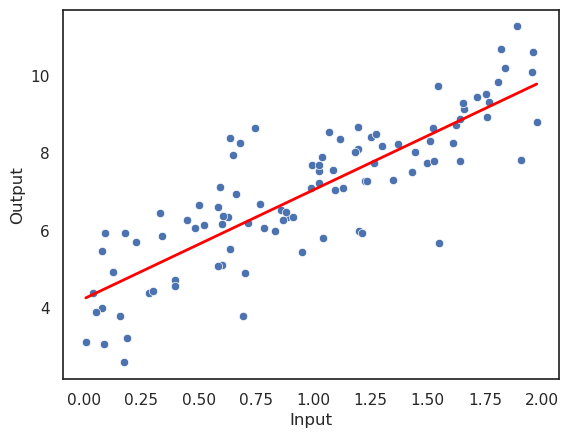

In [58]:
# Get predictions and plot
sns.set(style='white')
sns.lineplot(x=X.flatten(), y=model_output.flatten(), color='red', linewidth=2)
sns.scatterplot(x=X.flatten(), y=y.flatten())
plt.xlabel('Input')
plt.ylabel('Output')

In [59]:
# Print params
print(f'm = {model.w.detach().cpu().numpy()}')
print(f'b = {model.b.detach().cpu().numpy()}')

m = [[2.8157482]]
b = 4.226424694061279
